In [11]:
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from glob import glob
import cv2
import os
import numpy as np

N_CLUSTERS = 5


def load_image(path):
    #read image
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.reshape((img.shape[0] * img.shape[1], 3))
    return img


def fex(img, n_clusters):
    #using k-means to cluster pixels
    kmeans = KMeans(n_clusters)
    kmeans.fit(img)

    #the cluster centers are our dominant colour_clusters.
    colour_clusters = kmeans.cluster_centers_
    colour_clusters = colour_clusters.astype(int)

    n_labels = np.arange(0, n_clusters+1)
    (hist, _) = np.histogram(kmeans.labels_, bins=n_labels)
    hist = hist.astype("float")
    hist /= hist.sum()

    #descending order sorting as per frequency count
    colour_clusters = colour_clusters[(-hist).argsort()]
    hist = hist[(-hist).argsort()] 

    #creating empty chart
    chart = np.zeros((50, 500, 3), np.uint8)
    start = 0

    cluster_frequencies = np.array([[]])

    #creating color rectangles
    for i in range(n_clusters):
        end = start + hist[i] * 500

        cluster_frequencies = np.append(cluster_frequencies, hist[i])

        #getting rgb values
        r = colour_clusters[i][0]
        g = colour_clusters[i][1]
        b = colour_clusters[i][2]

        #using cv2.rectangle to plot colour_clusters
        cv2.rectangle(chart, (int(start), 0), (int(end), 50), (r,g,b), -1)
        start = end

    #display chart
    #     plt.figure()
    #     plt.axis("off")
    #     plt.imshow(chart)
    #     plt.show()
    #     print 
    #     print "acluster_frequencies dimension ", cluster_frequencies.ndim
    #     print cluster_frequencies
    outarr = np.zeros(len(colour_clusters)*4)
    for i in range(len(colour_clusters)):
        outarr[4*i:4*i+3] = colour_clusters[i]
        outarr[4*(i+1)-1] = cluster_frequencies[i]

    return outarr

main_path = '/Users/frodo/tf_files/deckchair/'

features = []
labels = []
extension = '.jpg'
for directory in glob(main_path+'*'):
    print "TRAINING ON " + directory
    for img in os.listdir(directory):
        if img.endswith(extension):
#             print img
            img_path = os.path.join(directory,img)
            img = load_image(img_path)
            feature = fex(img,N_CLUSTERS)
            features.append(feature)
            label = directory.split('/')[-1]
            labels.append(label)
#         print label
        
features = np.array(features)
labels = np.array(labels)

TRAINING ON /Users/frodo/tf_files/deckchair/gray_sky
TRAINING ON /Users/frodo/tf_files/deckchair/sunset


In [71]:
clf = svm.SVC(gamma=0.001)
clf.fit(features, labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [81]:
# create dictionary with results 
test_directory = '/Users/frodo/Desktop/timestamp-selected-sunset_resize'
test_feature = np.zeros(len(features)*4)
test_features = []
predicted_labels = []
results = {}
for img in os.listdir(test_directory):
    if img.endswith('.jpg'):
        img_path = os.path.join(test_directory,img)
        image = load_image(img_path)
        test_feature = fex(image,N_CLUSTERS)
        test_features.append(test_feature)
        predicted_label = clf.predict(np.array([test_feature]))
        predicted_labels.append(predicted_label)
        results[img] = predicted_label

TypeError: cannot perform reduce with flexible type

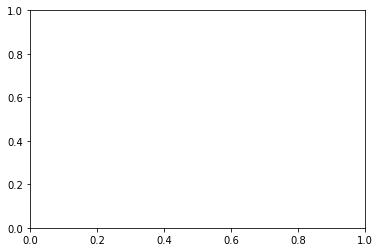

In [298]:
##### from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
label_ids = []
for label in labels:
    if label == 'sunset':
        label_id = 1
        label_ids.append(label_id)
    else:
        label_id = 0
        label_ids.append(label_id)
label_ids = np.array(label_ids)

# try to use a hard-coded dictionary
# tro try the filler_feature_values argument 
# in plot_decision_regions, as this is required 
# when working with more than two features
d = {1:10,2:20,3:50,4:60,5:50,
     6:50,7:90,8:80,9:60,10:10,
     11:30,12:30,13:40,14:10,15:40,
     16:30,17:40,18:50,19:20}
    
plot_decision_regions(features, label_ids, clf=clf,
                      filler_feature_values=d,
                      filler_feature_ranges=d)#legend=2, ax=ax)
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')

plt.show()


In [261]:
from PIL import Image, ImageDraw, ImageFont
import time 

# show image test with predicted label
font_type = ImageFont.truetype('Arial.ttf',18)
for k, v in results.iteritems():    
    image = Image.open(os.path.join(test_directory,k))
    label_to_write = str(v[0])
    draw = ImageDraw.Draw(image)
    draw.text(xy=(50,50),text=str(v[0]),fill=(0,0,0),font=font_type)
#     image.show()
#     time.sleep(0.5)
#     raw_input("Press Enter to continue...")